### Explore surface Argo oxygen float and World Ocean Atlas data
*Get cached surface data and compare with data from the World Ocean Atlas*

Build small local cache of some upper 10 decibar data:

```bash
scripts/load_cache.py --age 2700 --pressure 10 -v
```

Add parent directory to the path and get an ArgoData object that uses the local cache built with above command.

In [1]:
import sys
sys.path.insert(0, '../')

from oxyfloat import ArgoData
ad = ArgoData(cache_file='../oxyfloat/oxyfloat_fixed_cache_age2700_pressure10.hdf')

Get a Pandas DataFrame of all the data in this cache file.

In [2]:
%%time
wmo_list = ad.get_oxy_floats_from_status(2700)
df = ad.get_float_dataframe(wmo_list)

CPU times: user 20.5 s, sys: 489 ms, total: 21 s
Wall time: 50.7 s


See where these floats have been (bounding box coordinates adjusted).

Populating the interactive namespace from numpy and matplotlib


/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


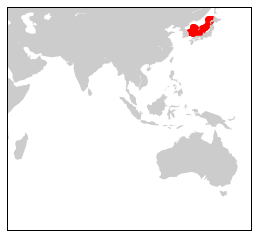

In [3]:
%pylab inline
import pylab as plt
from mpl_toolkits.basemap import Basemap

def map(lons, lats):
    m = Basemap(llcrnrlon=40, llcrnrlat=-60, urcrnrlon=160, urcrnrlat=50, projection='cyl')
    m.fillcontinents(color='0.8')
    m.scatter(lons, lats, latlon=True, color='red')

map(df.index.get_level_values('lon'), df.index.get_level_values('lat'))

Collapse the surface values into a single value with a `.mean()` (can try doing a `.median()`).

In [4]:
import pandas as pd
sdf = df.query('pressure < 10').groupby(level=['wmo', 'time', 'lon', 'lat']).mean()
sdf.head()

DOXY_ADJUSTED  \
wmo     time                       lon     lat                     
2900791 2006-09-20 09:29:52.972800 129.959 37.144     234.593185   
        2006-09-30 09:48:41.011200 129.824 37.221     212.985397   
        2006-10-10 10:03:30.499200 129.797 37.359     209.771835   
        2006-10-20 10:11:33.993600 129.678 37.574     223.353577   
        2006-10-30 10:07:38.985600 129.863 37.456     245.136032   

                                                   PSAL_ADJUSTED  \
wmo     time                       lon     lat                     
2900791 2006-09-20 09:29:52.972800 129.959 37.144      32.660000   
        2006-09-30 09:48:41.011200 129.824 37.221      32.917999   
        2006-10-10 10:03:30.499200 129.797 37.359      32.834000   
        2006-10-20 10:11:33.993600 129.678 37.574      32.723999   
        2006-10-30 10:07:38.985600 129.863 37.456      33.106998   

                                                   TEMP_ADJUSTED  
wmo     time                       lon     lat                    
2900791 2006-09-20 09:29:52.972800 129.959 37.144      23.056999  
        2006-09-30 09:48:41.011200 129.824 37.221      23.195999  
        2006-10-10 10:03:30.499200 129.797 37.359      21.874001  
        2006-10-20 10:11:33.993600 129.678 37.574      20.188000  
        2006-10-30 10:07:38.985600 129.863 37.456      17.419001

Before computing monthly means let's add lat, lon, wmo, and month and year numbers to the DataFrame.

In [5]:
sdf['lon'] = sdf.index.get_level_values('lon')
sdf['lat'] = sdf.index.get_level_values('lat')
sdf['month'] = sdf.index.get_level_values('time').month
sdf['year'] = sdf.index.get_level_values('time').year
sdf['wmo'] = sdf.index.get_level_values('wmo')

Compute the monthly means and add percent saturation column using the Gibbs SeaWater Oceanographic Package of TEOS-10.

In [6]:
msdf = sdf.groupby(['wmo', 'year', 'month']).mean()

from oxyfloat.utils import o2sat, convert_to_mll
msdf['o2sat'] = 100 * (msdf.DOXY_ADJUSTED / o2sat(msdf.PSAL_ADJUSTED, msdf.TEMP_ADJUSTED))
msdf.head(10)

DOXY_ADJUSTED  PSAL_ADJUSTED  TEMP_ADJUSTED         lon  \
wmo     year month                                                            
2900791 2006 9         223.789291      32.789000      23.126499  129.891500   
             10        226.087148      32.888332      19.827000  129.779333   
             11        198.039803      33.677500      17.949499  130.361500   
             12        217.958344      33.867001      15.691000  131.073500   
        2007 1         232.876770      34.074570      13.600500  130.967000   
             4         280.649780      34.340000      12.953000  130.531000   
             6         234.491043      34.237999      18.377001  131.320000   
             7         218.986786      33.944000      20.979000  131.656000   
             8         232.108266      33.630000      24.412333  131.871333   
             9         210.026382      32.914332      22.781000  132.062333   

                          lat       o2sat  
wmo     year month                         
2900791 2006 9      37.182500  103.571843  
             10     37.463000   98.707725  
             11     37.569000   83.929838  
             12     37.507000   88.542520  
        2007 1      37.297000   90.845943  
             4      37.014000  108.234179  
             6      37.034000  100.561157  
             7      36.841000   98.316178  
             8      36.986000  110.424183  
             9      37.012667   96.697382

Add columns `ilon` & `ilat` ('i', for index) rounding lat and lon to nearest 0.5 degree mark to facilitate lookups from the World Ocean Atlas. 

In [7]:
def round_to(n, increment, mark):
    correction = mark if n >= 0 else -mark
    return int( n / increment) + correction

imsdf = msdf.copy()
imsdf['ilon'] = msdf.apply(lambda x: round_to(x.lon, 1, 0.5), axis=1)
imsdf['ilat'] = msdf.apply(lambda x: round_to(x.lat, 1, 0.5), axis=1)
imsdf.head()

DOXY_ADJUSTED  PSAL_ADJUSTED  TEMP_ADJUSTED         lon  \
wmo     year month                                                            
2900791 2006 9         223.789291      32.789000      23.126499  129.891500   
             10        226.087148      32.888332      19.827000  129.779333   
             11        198.039803      33.677500      17.949499  130.361500   
             12        217.958344      33.867001      15.691000  131.073500   
        2007 1         232.876770      34.074570      13.600500  130.967000   

                        lat       o2sat   ilon  ilat  
wmo     year month                                    
2900791 2006 9      37.1825  103.571843  129.5  37.5  
             10     37.4630   98.707725  129.5  37.5  
             11     37.5690   83.929838  130.5  37.5  
             12     37.5070   88.542520  131.5  37.5  
        2007 1      37.2970   90.845943  130.5  37.5

Build a dictionary (`woa`) of OpenDAP monthly URLs to the o2sat data.

In [8]:
woa_tmpl = 'http://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATA/o2sat/netcdf/all/1.00/woa13_all_O{:02d}_01.nc'
woa = {}
for m in range(1,13):
    woa[m] = woa_tmpl.format(m)

Define a function to get WOA `O_an` (Objectively analyzed mean fields for fractional_saturation_of_oxygen_in_seawater at standard depth) variable given a month, depth, latitude, and longitude.

In [9]:
import xray
def woa_o2sat(month, depth, lon, lat):
    ds = xray.open_dataset(woa[month], decode_times=False)
    return ds.loc[dict(lon=lon, lat=lat, depth=depth)]['O_an'].values[0]

Add the woa_o2sat column to our DataFrame.

In [10]:
%%time
woadf = imsdf.copy()
woadf['month'] = woadf.index.get_level_values('month')
woadf['woa_o2sat'] = woadf.apply(lambda x: woa_o2sat(x.month, 5.0, x.ilon, x.ilat), axis=1)

CPU times: user 1.73 s, sys: 125 ms, total: 1.85 s
Wall time: 1min 15s


The above takes about 3 minutes to do the WOA lookups, so let's copy the 'o2' coluimns of the result to a DataFrame that we'll use for calculating the gain over time for each float. Add `wmo` column back and make a Python datetime index.

In [11]:
gdf = woadf[['o2sat', 'woa_o2sat']].copy()
gdf['wmo'] = gdf.index.get_level_values('wmo')
years = gdf.index.get_level_values('year')
months = gdf.index.get_level_values('month')
gdf['date'] = pd.to_datetime(years * 100 + months, format='%Y%m')

Plot the gain over time for each of the floats.

/home/mccann/VirtualEnvs/oxyfloat/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


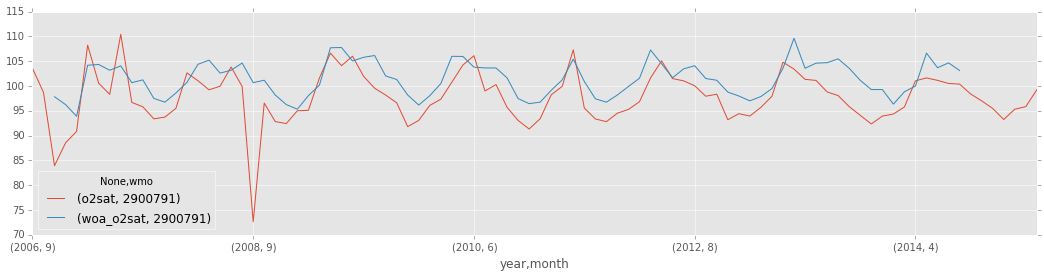

In [12]:
import matplotlib as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18.0, 4.0)
gdf[['o2sat', 'woa_o2sat']].unstack(level=0).plot()
##gdf['gain'] = gdf.woa_o2sat / gdf.o2sat
##gdf
#gdf.groupby(level=['wmo']).gain.mean()
##gdf.gain.unstack('wmo').plot()
##plot(gdf.date, gdf..gain)

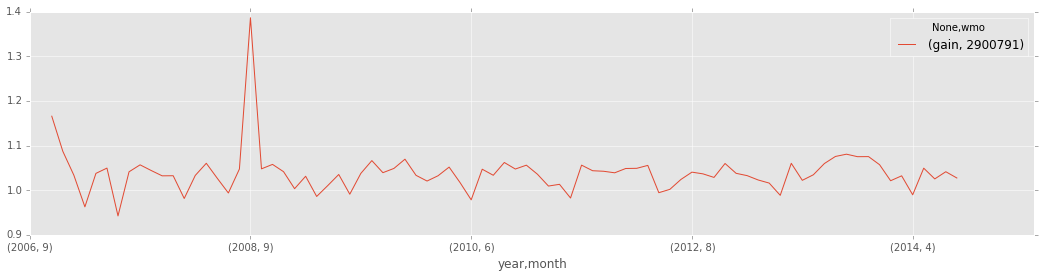

In [13]:
gdf['gain'] = gdf.woa_o2sat / gdf.o2sat
gdf[['gain']].unstack(level=0).plot()

In [17]:
gdf.gain.mean()

1.0390079718347851